<a href="https://colab.research.google.com/github/pravinkr/cats-and-dogs-vgg-keras/blob/master/cat_vs_dogs_with_vgg3_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Simple CNN model for dogs and cats dataset
import numpy as np


import numpy as np
import os
from keras.datasets import cifar10, cifar100
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.initializers import glorot_uniform
from keras import backend as K

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import skimage
from skimage.util import img_as_ubyte


Using TensorFlow backend.


In [0]:
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def load_dogs_vs_cats():

  %cd /content/gdrive/My Drive/kaggle
  #!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
  #!ls -ltr
  #!wget http://files.fast.ai/data/dogscats.zip
  #!echo '{"username":"USERNAME","key":"KEY"}' > /root/.kaggle/kaggle.json
  #!kaggle datasets download -d mmoreaux/environmental-sound-classification-50
  #!kaggle competitions download -c dogs-vs-cats
  
  !mkdir /content/dogs-vs-cats
  %cd /content/dogs-vs-cats/
  !mkdir dataset
  !cp /content/gdrive/My\ Drive/kaggle/test1.zip /content/dogs-vs-cats/dataset/
  !cp /content/gdrive/My\ Drive/kaggle/train.zip /content/dogs-vs-cats/dataset/
  %cd /content/dogs-vs-cats/dataset
  #!unzip test1.zip
  !unzip train.zip
  %cd /content

In [0]:
load_dogs_vs_cats()

/content/gdrive/My Drive/kaggle
mkdir: cannot create directory ‘/content/dogs-vs-cats’: File exists
/content/dogs-vs-cats
mkdir: cannot create directory ‘dataset’: File exists
/content/dogs-vs-cats/dataset
Archive:  train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.10000.jpg     
  inflating: train/cat.10001.jpg     
  inflating: train/cat.10002.jpg     
  inflating: train/cat.10003.jpg     
  inflating: train/cat.10004.jpg     
  inflating: train/cat.10005.jpg     
  inflating: train/cat.10006.jpg     
  inflating: train/cat.10007.jpg     
  inflating: train/cat.10008.jpg     
  inflating: train/cat.10009.jpg     
  inflating: train/cat.1001.jpg      
  inflating: train/cat.10010.jpg     
  inflating: train/cat.10011.jpg     
  inflating: train/cat.10

In [0]:
#Defining Variables

#model_type = 'Alexnet'
#model_type = 'ResNet50'
#model_type = 'vgg16'
#model_type  = 'model1'
#model_type = 'vgg1'
#model_type = 'vgg2'
model_type = 'vgg3'

#Data set information
#DATASET = 'cifar-10'
DATASET = 'dogs-vs-cats'
#DATASET = 'cifar-100'
input_shape=(32,32,3)

dataset_name = DATASET

if DATASET == 'cifar-10':
  num_classes = 10
elif DATASET == 'cifar-100':
  num_classes = 100
elif DATASET == 'dogs-vs-cats':
  num_classes = 1
  input_shape=(200,200,3)

IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = input_shape[0],input_shape[1],input_shape[2]

#Model Parameters



epochs = 50
lrate = 0.001
decay = lrate/epochs
batch_size = 64

data_augmentation = True
flow_from_dir = True

subtract_mean = True
seed = 7
np.random.seed(seed)




In [0]:
!pwd

/content


In [0]:
  home_dir = os.getcwd()
  model_home_dir = os.path.join(os.getcwd(),dataset_name) #,model_type)
  print(model_home_dir)
  if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

  model_save_dir = os.path.join(model_home_dir ,model_type)
  print(model_save_dir)
  if not os.path.isdir(model_save_dir):
    print('Inside mkdir')
    os.makedirs(model_save_dir)

  model_data_dir = os.path.join(model_home_dir ,'dataset')
  print(model_data_dir)
  if not os.path.isdir(model_data_dir):
    print('Inside mkdir')
    os.makedirs(model_data_dir)

  validate_dir = os.path.join(model_data_dir,"test")
  train_dir = os.path.join(model_data_dir,"train")


  print("train dir: ",train_dir)
  print("test dir: ",validate_dir)
  # Prepare model model saving directory.
  save_dir = os.path.join(model_home_dir, 'saved_models')

  #model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
  model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

  if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
  
  filepath = os.path.join(save_dir, model_name)
  print("Model Type: ",model_type)
  print("Model File: ",filepath)

  # create directories
  
  subdirs = ['train', 'test']
  for subdir in subdirs:
	  # create label subdirectories
	  labeldirs = ['dogs', 'cats']
	  for labldir in labeldirs:
		  newdir = os.path.join(model_data_dir,subdir,labldir)
		  os.makedirs(newdir, exist_ok=True)


print('TRAIN DIR: ',train_dir)
print('VALIDATE DIR: ',validate_dir)

/content/dogs-vs-cats
/content/dogs-vs-cats/ResNet50
Inside mkdir
/content/dogs-vs-cats/dataset
train dir:  /content/dogs-vs-cats/dataset/train
test dir:  /content/dogs-vs-cats/dataset/test
Model Type:  ResNet50
Model File:  /content/dogs-vs-cats/saved_models/dogs-vs-cats_ResNet50_model.{epoch:03d}.h5
TRAIN DIR:  /content/dogs-vs-cats/dataset/train
VALIDATE DIR:  /content/dogs-vs-cats/dataset/test


In [0]:
os.chdir(train_dir)
!pwd

/content/dogs-vs-cats/dataset/train


/content/dogs-vs-cats/dataset/train/dog.0.jpg
/content/dogs-vs-cats/dataset/train/dog.1.jpg
/content/dogs-vs-cats/dataset/train/dog.2.jpg
/content/dogs-vs-cats/dataset/train/dog.3.jpg
/content/dogs-vs-cats/dataset/train/dog.4.jpg
/content/dogs-vs-cats/dataset/train/dog.5.jpg
/content/dogs-vs-cats/dataset/train/dog.6.jpg
/content/dogs-vs-cats/dataset/train/dog.7.jpg
/content/dogs-vs-cats/dataset/train/dog.8.jpg


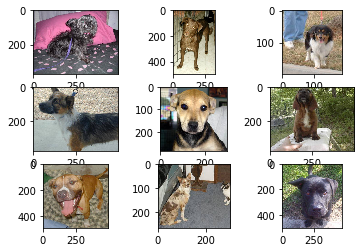

In [0]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	#filename = folder + 'dog.' + str(i) + '.jpg'
	file = 'dog.' + str(i) + '.jpg'
	#filename = os.path.join(model_data_dir,file)
	filename = os.path.join(train_dir,file)
	print(filename)
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

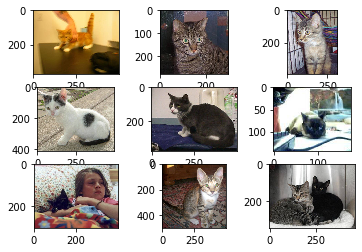

In [0]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	file = 'cat.'+str(i)+'.jpg'
	filename = os.path.join(train_dir,file)
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [0]:
model_data_dir,train_dir,validate_dir

('/content/dogs-vs-cats/dataset',
 '/content/dogs-vs-cats/dataset/train',
 '/content/dogs-vs-cats/dataset/test')

In [0]:

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories

os.chdir(train_dir)

#src_directory = 'train/'
src_directory = train_dir
for file in listdir(src_directory):
	print("file: ",file)
	#src = src_directory + '/' + file
	src = os.path.join(src_directory,file)
	if not os.path.isdir(src):
		print("src: ",src)
		#dst_dir = 'train/'
		dst_dir = train_dir
		if random() < val_ratio:
			#dst_dir = 'test/'
			dst_dir = validate_dir
		if file.startswith('cat'):
			#dst = model_data_dir + dst_dir + 'cats/'  + file
			dst = os.path.join(dst_dir,'cats',file)
			copyfile(src, dst)
		elif file.startswith('dog'):
			dst = os.path.join(dst_dir,'dogs',file)
			copyfile(src, dst)

In [0]:
%cd /content

/content


In [0]:
if flow_from_dir:
  if DATASET == 'cifar-10':
    %pip install cifar2png
    %cifar2png cifar10 "data"

In [0]:
if not flow_from_dir:
  #load data
  if DATASET == 'cifar-10':
    (X_train, y_train),(X_test,y_test) = cifar10.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype
  elif DATASET == 'cifar-100':
    (X_train, y_train),(X_test,y_test) = cifar100.load_data()
    X_train.shape, X_test.shape, X_train.shape[1:],X_train.dtype

  #Plot data
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(X_train[i])
  plt.show() 
  


In [0]:
def convert_to_imagenet_size(images):
  tmp_images = []
  for image in images:
    image = skimage.transform.resize(image,(224,224),mode='constant')
    image = img_as_ubyte(image)
    tmp_images.append(image)
  return np.array(tmp_images)

In [0]:
#Data Normalization
if not flow_from_dir:
  if not data_augmentation:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.
    X_test = X_test/255.

    if subtract_mean:
      X_train_mean = np.mean(X_train)
      X_train -= X_train_mean
      X_test_mean = np.mean(X_test)
      X_test -= X_test_mean

  print(y_train.shape, y_test.shape)

In [0]:
if not flow_from_dir:
  y_train = np_utils.to_categorical(y_train)
  y_test = np_utils.to_categorical(y_test)
  print(y_train.shape, y_test.shape)

In [0]:
#num_classes = y_train.shape[1]
#input_shape=X_train.shape[1:]

input_shape,num_classes

((200, 200, 3), 2)

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def ResNet50(input_shape=(32, 32, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    #X = Dense(classes, activation='sigmoid', name='fc' + str(1), kernel_initializer = glorot_uniform(seed=0))(X)
    #model.add(Dense(1, activation='sigmoid'))
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [0]:
def vgg16(input_shape=(32,32,3), num_classes=10):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  #model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Dropout(0.3))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=num_classes, activation="softmax"))

	# compile model
  opt = SGD(lr=lrate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


  return model

In [0]:
#Define Alexnet Model
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))

  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  #model.summary()
  return model

In [0]:
def my_model(input_shape,num_classes):
  # Create the model - Normal model with CNN, dropouts and MaxPooling.
  # This model gives accuracy of 77% on the test set after 25 epochs

  model = Sequential()

  #model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu'))
  model.add(Conv2D(32,(3,3),input_shape=input_shape,padding='same',activation='relu'))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(num_classes,activation='softmax'))

  return model



In [0]:
def vgg1(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  #opt = SGD(lr=lrate, momentum=0.9)
  #model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model


In [0]:
def model1(input_shape,num_classes):

	
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	
	model.add(Conv2D(128, (3, 3), activation='relu'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	
	model.add(Flatten())
	model.add(Dense(512, activation='relu'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
	
	return model

In [0]:
def vgg2(input_shape, num_classes):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
	# compile model
  opt = SGD(lr=lrate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 
  return model

In [0]:
def vgg3(input_shape,num_classes):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

#callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]
callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [0]:
def define_model(model_type, num_classes):
  if num_classes == 2:
    num_classes = 1
  #model = my_model(input_shape,num_classes)
  if model_type == 'Alexnet':
    #input_shape = (224,224,3)
    model = AlexnetModel(input_shape,num_classes)
  elif model_type == 'ResNet50':
    model = ResNet50(input_shape,num_classes)
  elif model_type == 'vgg16':
    model = vgg16(input_shape,num_classes)
  elif model_type == 'model1':
    model = model1(input_shape,num_classes)
  elif model_type == 'vgg1':
    model = vgg1(input_shape,num_classes)
  elif model_type == 'vgg2':
    print("model: ",model_type)
    model = vgg2(input_shape,num_classes)
  elif model_type == 'vgg3':
    model = vgg3(input_shape,num_classes)
  else:
    model = my_model(input_shape,num_classes)

# Compile model

  optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
  #optimizer = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, amsgrad=False)
  #model.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
  #model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
  #print("Model Summary of ",model_type)
  #print(model.summary())

  return(model)



In [0]:
#load_dogs_vs_cats()



model = define_model(model_type,num_classes)
print("Model Summary of ",model_type)
print(model.summary())

Model Summary of  Alexnet
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 50, 50, 96)        2688      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 25, 25, 96)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 256)       614656    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_44 (Conv2D)         

In [0]:
if data_augmentation:

  train_datagen = ImageDataGenerator(rescale=1.0/255.0)

  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:

  
  '''
	train_datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.2,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.2,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=1./255,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
  
 '''
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).


if not flow_from_dir:
	if not data_augmentation:
		print('Not using data augmentation.')
		history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=callbacks)
	else:   
		print("model using data from downloaded dataset in memoory")
		train_datagen.fit(X_train)
		# Fit the model on the batches generated by datagen.flow().
		history = model.fit_generator(train_datagen.flow(X_train, y_train,
                                 batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=validation_datagen.flow((X_test, y_test),batch_size=batch_size),
                                 workers=4,
                                 callbacks=callbacks)
  
	scores = model.evaluate(X_test, y_test, verbose=1)

else:
	# generator for reading train data from folder

	print('Model fit using flow from directory')
	print("Train Dir: ",train_dir)
	print("Validation Dir: ",validate_dir)
  

	'''
	train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size = (input_shape[0],input_shape[1]),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'binary',
      shuffle=False,
      seed=42
      )
	#
	# generator for reading validation data from folder

	validation_generator = validation_datagen.flow_from_directory(
      validate_dir,
      target_size = (input_shape[0],input_shape[1]),
      color_mode = 'rgb',
      batch_size = batch_size,
      class_mode = 'binary',
      shuffle=False,
      seed=42)
  '''

	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
  
	# prepare iterator
	train_generator = datagen.flow_from_directory(train_dir,
		class_mode='binary', batch_size=64, target_size=(200, 200))
 
	validation_generator = datagen.flow_from_directory(validate_dir,
		class_mode='binary', batch_size=64, target_size=(200, 200))

	STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
	STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

	print("len(train_generator): ",len(train_generator))
	print("STEP_SIZE_TRAIN: ",STEP_SIZE_TRAIN)

  # fit model
	history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, #steps_per_epoch=len(train_generator),
		validation_data=validation_generator, validation_steps=STEP_SIZE_VALID, epochs=epochs, verbose=1
    ,callbacks=callbacks)
 
	# evaluate model
	scores = model.evaluate_generator(validation_generator, steps=STEP_SIZE_VALID, verbose=1)
	print('> %.3f' % (scores[1] * 100.0))





	''' 
	history = model.fit_generator(generator=train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                epochs=epochs,
                callbacks=callbacks
                )
  
	scores = model.evaluate_generator(generator=validation_generator,
                           steps=STEP_SIZE_VALID, verbose=1)

  '''
	#Predict the output
	''' Use when to Predict the output
	STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
	test_generator.reset()
	pred=model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

	'''
# Save model and weights



# Score trained model.

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [0]:
!ls -ltr

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory(train_dir,
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory(validate_dir,
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()